In [1]:
# import packages
import requests
import os
import pandas as pd
import tweepy
import json
import numpy as np

Download image prediction from the URL

In [2]:
# download tweet image predictions
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
folder_name = url.split('/')[-1]
if not os.path.exists(folder_name):
    r = requests.get(url)
    with open(folder_name, mode='wb') as file:
        file.write(r.content)

Check twitter_archive file

In [3]:
# see what information twitter archive has
df = pd.read_csv('twitter-archive-enhanced.csv')
df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


Check image file

In [4]:
# see what information image predictions have
df_image = pd.read_csv('image-predictions.tsv', sep='\t')
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


After applying tweet developer from tweet, I'm going to use the tweet ids from archive (twitter-archive-enhanced.csv) and Tweeter API to gather additional information about those tweets. There's a limit on how many tweets you can get every 15 minutes. When the limit is reached, the algorithm will wait until next 15 minutes and then continue.

In [5]:
# authenticate and access twitter API
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# gather tweets if it hasn't been done before
if not os.path.exists('tweet_json.txt'):
    tweet_extra = {}
    tweet_extra['tweets'] = []
    # get tweet information for each tweet id
    for indx, tweet_id in enumerate(df.tweet_id):
        # see where we're in the process
        # because it can take a while
        if (indx+1)%50 == 0:
            print('{} tweets have been viewed.'.format(indx+1))
        # Some tweets can't be found and throw an error
        try:
            tweet = api.get_status(id = tweet_id)
            tweet_extra['tweets'].append({
                "tweet_id": tweet_id,
                "retweet_count": tweet.retweet_count,
                "favorite_count": tweet.favorite_count,
            })
        # record the tweets that can't be found
        except:
            print('{} tweet id doesn\'t exist'.format(tweet_id))

    # save tweets as json object into a text file
    with open('tweet_json.txt', 'w') as outfile:
        json.dump(tweet_extra, outfile, default=str)

Load json text file and create a dataframe

In [7]:
with open('tweet_json.txt') as json_file:
    data = json.load(json_file)
df_tweet = pd.DataFrame(data['tweets'])
df_tweet.head()

,favorite_count,retweet_count,tweet_id
0,38233,8375,892420643555336193
1,32780,6184,892177421306343426
2,24687,4092,891815181378084864
3,41566,8516,891689557279858688
4,39746,9221,891327558926688256


## Assess##

In this section, I'll check each dataset and find quality and tidiness issues.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [9]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
favorite_count    2342 non-null int64
retweet_count     2342 non-null int64
tweet_id          2342 non-null object
dtypes: int64(2), object(1)
memory usage: 55.0+ KB


In [11]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [13]:
df_tweet.describe()

,favorite_count,retweet_count
count,2342.000000,2342.000000
mean,8005.246371,2953.390265
std,12389.832790,4966.795350
min,0.000000,0.000000
25%,1383.500000,592.500000
50%,3484.000000,1379.500000
75%,9809.750000,3445.750000
max,165009.000000,84184.000000


In [14]:
df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2225,668286279830867968,NaN,NaN,2015-11-22 04:33:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rusty. Rusty's dreaming of a world where ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668286279...,11,10,Rusty,None,None,None,None
942,752917284578922496,NaN,NaN,2016-07-12 17:27:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Grizzie. She's a semi-submerged Bahrai...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/752917284...,11,10,Grizzie,None,None,None,None
1083,738537504001953792,NaN,NaN,2016-06-03 01:07:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bayley. She fell asleep trying to esca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/738537504...,11,10,Bayley,None,None,None,puppo
1722,680115823365742593,NaN,NaN,2015-12-24 20:00:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ozzy. He woke up 2 minutes before he h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680115823...,9,10,Ozzy,None,None,None,None
2076,670838202509447168,NaN,NaN,2015-11-29 05:34:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Pink dogs here. Unreasonably long necks. Left ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670838202...,4,10,None,None,None,None,None
2239,667937095915278337,NaN,NaN,2015-11-21 05:26:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog resembles a baked potato. Bed looks u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667937095...,3,10,None,None,None,None,None
1210,715680795826982913,NaN,NaN,2016-03-31 23:22:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zeus. He's downright fabulous. 12/10 h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/715680795...,12,10,Zeus,None,None,None,None
597,798694562394996736,NaN,NaN,2016-11-16 01:09:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: I'm not sure what's happening h...,7.012147e+17,4.196984e+09,2016-02-21 01:19:47 +0000,https://twitter.com/dog_rates/status/701214700...,12,10,None,None,None,None,None
2310,666786068205871104,NaN,NaN,2015-11-18 01:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unfamiliar with this breed. Ears pointy af. Wo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666786068...,2,10,None,None,None,None,None
772,776477788987613185,NaN,NaN,2016-09-15 17:48:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Huck. He's addicted to caffeine. Hope ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776477788...,11,10,Huck,None,None,pupper,None


In [15]:
df_image.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1373,762471784394268675,https://pbs.twimg.com/ext_tw_video_thumb/76247...,1,Samoyed,0.540276,True,standard_poodle,0.279802,True,toy_poodle,0.102058,True
1277,750086836815486976,https://pbs.twimg.com/media/Cmf5WLGWYAAcmRw.jpg,1,pug,0.978277,True,teddy,0.003134,False,Brabancon_griffon,0.003061,True
1498,783695101801398276,https://pbs.twimg.com/media/CuA-iRHXYAAWP8e.jpg,3,chow,0.314265,True,golden_retriever,0.300435,True,Australian_terrier,0.049487,True
1634,805958939288408065,https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg,1,Irish_setter,0.574557,True,golden_retriever,0.339251,True,seat_belt,0.046108,False
1264,749064354620928000,https://pbs.twimg.com/media/CmU2DVWWgAArvp3.jpg,2,pug,0.985222,True,Brabancon_griffon,0.003314,True,Pekinese,0.002989,True
1949,863062471531167744,https://pbs.twimg.com/media/C_o2vKCUwAAgtOp.jpg,2,French_bulldog,0.935804,True,pug,0.059576,True,boxer,0.001412,True
427,674255168825880576,https://pbs.twimg.com/media/CVtvf6bWwAAd1rT.jpg,1,Eskimo_dog,0.615741,True,Siberian_husky,0.199544,True,malamute,0.179107,True
323,671874878652489728,https://pbs.twimg.com/media/CVL6op1WEAAUFE7.jpg,1,china_cabinet,0.996031,False,entertainment_center,0.001986,False,bookcase,0.001652,False
1886,847962785489326080,https://pbs.twimg.com/media/C8SRpHNUIAARB3j.jpg,1,sea_lion,0.882654,False,mink,0.066880,False,otter,0.025679,False
177,669214165781868544,https://pbs.twimg.com/media/CUmGu7-UcAA0r3O.jpg,1,minivan,0.435396,False,police_van,0.310143,False,minibus,0.068201,False


In [16]:
df_tweet.sample(10)

,favorite_count,retweet_count,tweet_id
107,20787,5500,871102520638267392
797,8845,2870,771500966810099713
448,5185,866,817908911860748288
2077,833,408,670783437142401025
209,21373,6033,851224888060895234
418,9314,2207,821149554670182400
1386,6254,2804,699446877801091073
796,12828,3719,771770456517009408
2067,627,99,670822709593571328
901,6205,1899,757393109802180609


In [17]:
df.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Cooper      11
Lucy        11
Penny       10
Lola        10
Tucker      10
Winston      9
Bo           9
Sadie        8
the          8
Buddy        7
Bailey       7
Toby         7
an           7
Daisy        7
Oscar        6
Bella        6
Leo          6
Milo         6
Dave         6
Jack         6
Scout        6
Stanley      6
Jax          6
Rusty        6
Koda         6
Louis        5
          ... 
Mya          1
Rupert       1
Ferg         1
Scott        1
Nida         1
River        1
Severus      1
Bubba        1
Jarvis       1
JD           1
Bilbo        1
Beya         1
Yoda         1
Clarq        1
Newt         1
DonDon       1
Ralphie      1
Karma        1
Saydee       1
Jim          1
Zeek         1
Ricky        1
Bauer        1
Huxley       1
Bones        1
Jessiga      1
Samsom       1
Callie       1
Obi          1
Edgar        1
Name: name, Length: 957, dtype: int64

In [18]:
df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Quality:

Df sheet
1.	Retweet id are empty.
2.  Too many useless column.
3.	Timestamp is object.
4.	Tweet_id is integer.
5.	The biggest values of ratting denominator seems strange.
6.  The biggest values of ratting numerator is stange
7.  Numerator value should not under denominator.
8.	Lots of the dogs’ ‘name’ is None.
9.  Lots of the ‘doogo’ , ’floofer’ , ‘pupper’, and ‘puppo’ are None.
	

Df_image sheet
1.	Tweet_id is integer.

Df_tweet sheet
1.	Tweet_id is object.

Tidness:
1.	Doogo, floofer, pupper, puppo should be in one column.
2.	Df and df_tweet sheet can be combined to one sheet since the information are related.


## Clean ##

Before cleaning, I need to make a copy to each sheet.

In [19]:
df_clean = df.copy()
df_image_clean = df_image.copy()
df_tweet_clean = df_tweet.copy()

Quality issue

**1.Retweet id are empty**


*Define*

Remove empty retweet id.

*Code*

In [20]:
df_clean = df_clean[df_clean.retweeted_status_id.isnull()]

*Test*

In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

Quality issue

**2.Too many useless column**

*Define*

Drop useless, left useful columns to clean the datasheet.

*Code*

In [22]:
df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id',
               'retweeted_status_timestamp','source', 'expanded_urls'],axis=1,inplace=True)

*Test*

In [23]:
df_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


Quality issue

**3.Timestamp is object.**

*Define*

Transfer timestamp into datetime.

*Code*

In [24]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)

*Test*

In [25]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null datetime64[ns]
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 186.9+ KB


Quality issue

Df sheet

**4.Tweet_id is integer.**

Df_image sheet

**1.Tweet_id is integer.**

Df_tweet sheet

**1.Tweet_id is object.**

*Define*

Transfer all three sheets' Tweet_id into string


*Code*

In [26]:
df_clean.tweet_id = df_clean.tweet_id.astype(str)
df_image_clean.tweet_id = df_image_clean.tweet_id.astype(str)
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

*Test*

In [27]:
print(type(df_clean.tweet_id[0]))
print(type(df_image_clean.tweet_id[0]))
print(type(df_tweet_clean.tweet_id[0]))

<class 'str'>
<class 'str'>
<class 'str'>


Quality issue

**5.The biggest values of ratting denominator seems strange.**


*Define*

Change all denominator value to 10.

*Code*

In [28]:
df_clean.rating_denominator = df_clean.rating_denominator.apply(lambda x: 10 if x != 10 else x)

*Test*

In [29]:
df_clean.rating_denominator.value_counts()

10    2175
Name: rating_denominator, dtype: int64

Quality issue

**6. The biggest values of ratting numerator is stange**

*Define*

Change numerator value above 20 to 20.

*Code*

In [30]:
df_clean.rating_numerator = df_clean.rating_numerator.apply(lambda x: 20 if x > 20 else x)

*Test*

In [31]:
df_clean.rating_numerator.value_counts()

12    500
10    442
11    426
13    307
9     156
8      98
7      54
14     43
5      36
6      32
20     24
3      19
4      17
2       9
1       8
0       2
15      1
17      1
Name: rating_numerator, dtype: int64

Quality issue

**7.Numerator value should not under denominator.**

*Define*

Change numerator value below 10 to 10.

*Code*

In [32]:
df_clean.rating_numerator = df_clean.rating_numerator.apply(lambda x: 10 if x < 10 else x)

*Test*

In [33]:
df_clean.rating_numerator.value_counts()

10    873
12    500
11    426
13    307
14     43
20     24
17      1
15      1
Name: rating_numerator, dtype: int64

Quality issue

**8.Lots of the dogs’ ‘name’ is None.**

*Define*

Extract dogs' names from text.

*Code*

In [34]:
#Check how many dogs' names are none.
df_clean.query('name=="None"').shape[0]

680

In [35]:
# extract names from text
df_clean.name = df_clean.text.str.extract(
    '(?:This is|Meet|name is|Say hello to|named) ([A-Z][a-z]{2,12})', expand=False).values

*Test*

In [36]:
df_clean.query('name=="None"').shape[0]

0

Quality issue

**9. Lots of the ‘doogo’ , ’floofer’ , ‘pupper’, and ‘puppo’ are None.**

Tidness issue

**1.Doogo, floofer, pupper, puppo should be in one column.**


*Define*

Extract ‘doogo’ , ’floofer’ , ‘pupper’, and ‘puppo’ from text, and combine those four column into one.

*Code*



In [37]:
#Add new column
df_clean['rank'] = None

In [38]:
# Extract doogo/floofer/pupper/puppo from text
import re
for i in df_clean.index:
    rank_set = set(re.findall('(doggo|floofer|pupper|puppo)', df_clean.loc[i,'text']))
    if len(rank_set) > 0:
        rank_value = ', '.join(rank_set)
        df_clean.loc[i, 'rank'] = rank_value

In [39]:
#Drop doogo/floofer/pupper/puppo column
df_clean.drop(['doggo', 'pupper','floofer','puppo'],axis=1,inplace=True)

*Test*

In [40]:
df_clean.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rank
731,781655249211752448,2016-09-30 00:41:48,This is Combo. The daily struggles of being a ...,11,10,Combo,doggo
358,830097400375152640,2017-02-10 16:53:37,Meet Samson. He's absolute fluffy perfection. ...,13,10,Samson,None
537,806629075125202948,2016-12-07 22:38:52,"""Good afternoon class today we're going to lea...",13,10,NaN,None
1928,674045139690631169,2015-12-08 01:57:39,Herd of wild dogs here. Not sure what they're ...,10,10,NaN,pupper
1341,704847917308362754,2016-03-02 01:56:53,"""Yes hi could I get a number 4 with no pickles...",12,10,NaN,None
1102,735274964362878976,2016-05-25 01:03:06,We only rate dogs. Please stop sending in your...,11,10,NaN,None
622,796080075804475393,2016-11-08 20:00:55,This is Yogi. He's 98% floof. Snuggable af. 12...,12,10,Yogi,None
2173,669324657376567296,2015-11-25 01:20:08,Meet Ralf. He's a miniature Buick DiCaprio. Ca...,11,10,Ralf,None
1992,672614745925664768,2015-12-04 03:13:46,This is Norman. Doesn't bark much. Very docile...,10,10,Norman,pupper
1985,672898206762672129,2015-12-04 22:00:08,This is Cheryl AKA Queen Pupper of the Skies. ...,11,10,Cheryl,None


Tidness issue

**2.Df and df_tweet sheet can be combined to one sheet since the information are related.**


*Define*

Combine Df_clean and df_tweet_clean sheet with tweet_id.

*Code*

In [41]:
df_clean1 = pd.merge(df_clean, df_tweet_clean, on=['tweet_id', 'tweet_id'])


*Test*

In [42]:
df_clean1.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,rank,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,38233,8375
1,892177421306343426,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,32780,6184
2,891815181378084864,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,24687,4092
3,891689557279858688,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,41566,8516
4,891327558926688256,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,39746,9221


***Save to CSV***

In [43]:
df_clean1.to_csv('twitter_archive_master.csv', index=False)
df_image_clean.to_csv('twitter_image.csv', index=False)

## Analyze##

In [44]:
# Import matplotilb

import matplotlib.pyplot as plt
% matplotlib inline

# 1. Does people who like the twitter, retweet it also?#

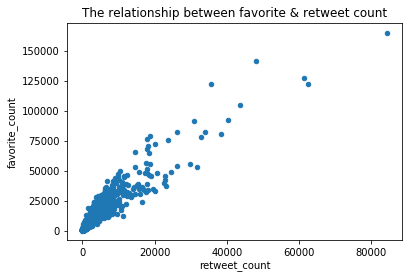

In [45]:
df_clean1.plot(x='retweet_count', y='favorite_count', kind='scatter');
plt.title('The relationship between favorite & retweet count');

According to above plot, the relationship between retweet_count and favorite_count is positive.
So, most people retweet the twitter they liked.

# 2.What is the distribution of rank? 

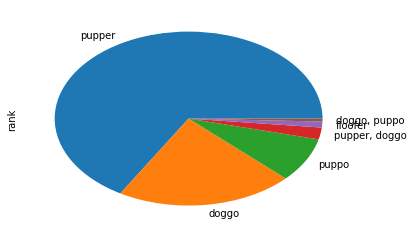

In [53]:
df_clean1['rank'].value_counts().plot(kind='pie');

Dogs are classfied as pupper most, and then are doggo.

# 3.Which ranked dog have more favorite counts?

In [47]:
df_clean1.groupby('rank').favorite_count.mean()

rank
doggo            16243.064103
doggo, puppo     31036.000000
floofer          17934.500000
pupper            6831.954545
pupper, doggo    13285.250000
puppo            20282.866667
Name: favorite_count, dtype: float64

The dog classifed as doggo, puppo has most favorite counts, while puppo is the second. 

# 4. What ranks have higher rating?

In [48]:
df_clean1.groupby('rank').rating_numerator.mean()

rank
doggo            11.961538
doggo, puppo     13.000000
floofer          12.250000
pupper           11.314050
pupper, doggo    11.375000
puppo            12.033333
Name: rating_numerator, dtype: float64

"Doggo, puppo" has the highest rating, this result can match that most people likes this rank.
Floofer and puppo are in the second and third rating, so is in favortie counts.